<a href="https://colab.research.google.com/github/Samarth1410/fmml-jan-/blob/main/Queue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from statsmodels.tsa.arima_process import ArmaProcess
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from itertools import product
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox



In [92]:
data = pd.read_csv('/content/temperature.csv')
data.rename(columns = {'Seattle':'AEP_MW', 'datetime':'Datetime'}, inplace = True)
data['AEP_MW'] = (data['AEP_MW']-data['AEP_MW'].min())*.5
data.head()

,Datetime,AEP_MW
0,01-10-2012 13:00,9.0
1,01-10-2012 14:00,9.0
2,01-10-2012 15:00,9.0
3,01-10-2012 16:00,9.0
4,01-10-2012 17:00,9.0


In [62]:
data['Datetime']= pd.to_datetime(data['Datetime'])

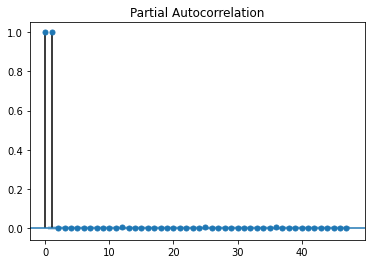

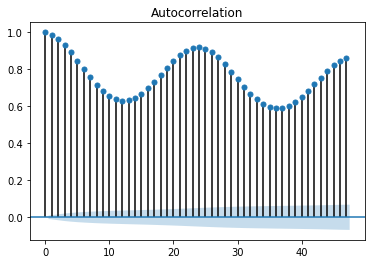

In [63]:
plot_pacf(data['Datetime']);
plot_acf(data['AEP_MW']);

In [64]:
ad_fuller_result = adfuller(data['AEP_MW'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

## The data is stationary.

ADF Statistic: -7.517225129445682
p-value: 3.874489506529275e-11


In [65]:
# Augmented Dickey-Fuller test
ad_fuller_result = adfuller(data['AEP_MW'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')


## Now the data is stationary, hence Augmented Regression can be used.

ADF Statistic: -7.517225129445682
p-value: 3.874489506529275e-11


In [66]:

def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(exog, order=order).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    print('hi')
    return result_df

In [67]:
ps = range(0, 2, 1)
d = 1
qs = range(0, 2, 1)
# Create a list with all possible combination of parameters

parameters = product(ps, qs)
parameters_list = list(parameters)
order_list = []
for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)
    
result_df = optimize_ARIMA(order_list, exog=data['AEP_MW'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


  0%|          | 0/4 [00:00<?, ?it/s]

hi


In [68]:
result_df

,"(p, d, q)",AIC
0,"(1, 1, 1)",127198.333687
1,"(1, 1, 0)",130429.032680
2,"(0, 1, 1)",132313.947626
3,"(0, 1, 0)",135433.801681


In [99]:
best_model = SARIMAX(data['AEP_MW'], order=(1,1,1),seasonal_order= (1, 1, 1, 12)).fit()
print(best_model.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                             AEP_MW   No. Observations:                45252
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -29019.829
Date:                            Sun, 31 Jul 2022   AIC                          58049.658
Time:                                    12:12:50   BIC                          58093.257
Sample:                                         0   HQIC                         58063.379
                                          - 45252                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9739      0.001    929.991      0.000       0.972       0.976
ma.L1         -0.9999      0.000  -

In [100]:
df=best_model.predict(start=len(data['Datetime']),end=len(data['Datetime'])+10,dynamic=True)

In [101]:
df

45252    9.474737
45253    9.164430
45254    9.135319
45255    8.898356
45256    9.001728
45257    8.927085
45258    8.938086
45259    8.859384
45260    8.628135
45261    8.437745
45262    8.426813
dtype: float64